## Step 0 : configure some ouput options

this operation will result in multiple files. Things will be tidier if you have a common output folder and prefix for all of them.

In [65]:
OUTPUT_FOLDER = 'output/'
OUTPUT_PREFIX = 'toy_data'

In [66]:
## use any of the colormap avalable by matplotlib : https://matplotlib.org/3.5.3/tutorials/colors/colormaps.html
COLORMAP='viridis'

## step 1 : read in your csv data

The idea is that you get a table with the first 3 columns corresponding to the X Y Z positions you want for your points.

The other columns will be used as metadata (for example, as a coloring option in the GUI).

In [67]:
import pandas as pd

df = pd.read_table("toyData/test_sc_data.txt", sep=" ", index_col=0)
df.head()

,PC_1,PC_2,PC_3,cell_line,KRT81,MT1E,SAA1,GAGE12D,SEC61G
Lib90_00000,8.349043,6.108142,-18.230019,HCC827,6,1,1,1,1200
Lib90_00002,-15.823000,13.018068,-0.204499,H838,5,0,0,167,32
Lib90_00003,9.062575,5.572152,-17.977929,HCC827,3,1,13,0,884
Lib90_00004,6.777374,5.176689,-19.057121,HCC827,0,1,6,1,1018
Lib90_00005,7.199729,7.374359,-14.528045,HCC827,1,0,1,1,998


# step 2 : extract labels

Labels are handled in separate files + the metadata columns should only contain numeric columns

Here, I list the label-containing columns

In [68]:
label_columns = ["cell_line"]


non_label_columns = [ c for c in df.columns[3:] if not c in label_columns  ]

Now, I create a new numeric column based-off of each label columns. 

This is not mandatory, but this be used to give me the option to color by label, which I want to have.

In [69]:
## let's keep the correspondences between original labels and their number-ID
label_columns_eq_table = {}

## we also track which columns we have added
label_columns_int_cols = []

for col in label_columns:
    label_columns_eq_table[col] = {s:i for i,s in  enumerate( df[col].unique() ) }
        
    df[col+"_int"] = df[col].replace( label_columns_eq_table[col] )
    label_columns_int_cols.append(col+"_int")

## step 3 : writing the speck file

The speck file contains the X Y Z positions of each of our points + additionnal metadata columns


I begin by defining some (optional) description for the columns

In [70]:
column_description= {'KRT81':'raw expression value for gene KRT81', 
                     'MT1E':'raw expression value for gene MT1E', 
                     'SAA1':'raw expression value for gene SAA1', 
                     'GAGE12D':'raw expression value for gene GAGE12D', 
                     'SEC61G':'raw expression value for gene SEC61G'}

Then automatically complement this with info on the transformed label columns:

In [71]:
for col in label_columns_int_cols:
    origin_col = col[:-4]
    column_description[col]="from column "+origin_col 
    
    # go from int to labels (so then we can give them in order...)
    reverse_labels = {v:k for k,v in label_columns_eq_table[origin_col].items() }
    for i in range(len(reverse_labels)):
        column_description[col]+=", {}:{}".format(i,reverse_labels[i])    

In [72]:
column_description

{'KRT81': 'raw expression value for gene KRT81',
 'MT1E': 'raw expression value for gene MT1E',
 'SAA1': 'raw expression value for gene SAA1',
 'GAGE12D': 'raw expression value for gene GAGE12D',
 'SEC61G': 'raw expression value for gene SEC61G',
 'cell_line_int': 'from column cell_line, 0:HCC827, 1:H838, 2:H1975, 3:H2228, 4:A549'}

In [73]:
## make a view of the table without the label columns
dft = df.drop(columns=label_columns)


with open(OUTPUT_FOLDER + OUTPUT_PREFIX + '.speck','w') as OUT:
    for i,col in enumerate( dft.columns[3:] ):
        print("datavar {} {} # {}".format(i,col, column_description.get(col,'')) , file=OUT )
    dft.to_csv( OUT , sep=' ' , index=False , header=False)

In [74]:
# !head -n 20 output/toy_data.speck

# step 4 : creating the labels files

There needs to be 1 file per label.


In [75]:
dft = df
dft['text'] = 'text' # this "text" column is used in the file format  

# these we will keep around
XYZcols = list( dft.columns[:3] )

for col in label_columns:
    dft2 = dft.loc[: , XYZcols + [ 'text', col]]
    file_name = OUTPUT_FOLDER + OUTPUT_PREFIX +'.'+col+".label"
    
    with open(file_name,'w') as OUT:
        print('textcolor 1',file=OUT)
        dft2.to_csv( OUT , sep=' ' , index=False , header=False)
        
    print('wrote label {} in file {}'.format(col,file_name))

wrote label cell_line in file output/toy_data.cell_line.label


In [76]:
# !head output/toy_data.cell_line.label

# step 5: create an appropriate colorMap

The goal is to create a color map which works for all of the columns.

So the idea is to reference the number of categories (observed, or desired for representation purpose) in each column.

Then create the colormap such that the number of colors is divisible by all the number of categories for each columns.

For exemple: imagine a case where we have 2 columns, one with 3 categories and the other with 7 


In [77]:
from collections import defaultdict

def prime_number_decomposition(n):
    ## prime number decomposition
    x=2

    PN = defaultdict(lambda : 0)
    while n != 1:
        while n%x==0:
            n /= x
            PN[x]+=1
        x += 1
    return PN

To somewhat limit the number of colors we have to create, we can limit the number of categories per column.

In [78]:
## we do not want to get overboard there.
## with a maximum number of categories at 16, 
## there will be at most 720720 colors to create
MAXIMUM_CAT_PER_COLUMN = 16


prime_sum = defaultdict(lambda : 0)

for col in label_columns_int_cols + non_label_columns:
    n = len(dft[col].unique())
    PN = prime_number_decomposition(min(n,MAXIMUM_CAT_PER_COLUMN))

    if n < MAXIMUM_CAT_PER_COLUMN:
        print("{} -> {} categories ({})".format(col, n , dict(PN)))
    else:
        print("{} -> {} categories -> limited to {} ({})".format(col, n, MAXIMUM_CAT_PER_COLUMN , dict(PN)))
        MAXIMUM_CAT_PER_COLUMN
    for k,v in PN.items():
        prime_sum[k] = max( v , prime_sum[k] )

nb_colors = 1
for n,p in prime_sum.items():
    nb_colors *= n**p
print("total number of colors to represent all categories of all colors : {}".format(nb_colors))

cell_line_int -> 5 categories ({5: 1})
KRT81 -> 422 categories -> limited to 16 ({2: 4})
MT1E -> 123 categories -> limited to 16 ({2: 4})
SAA1 -> 186 categories -> limited to 16 ({2: 4})
GAGE12D -> 133 categories -> limited to 16 ({2: 4})
SEC61G -> 461 categories -> limited to 16 ({2: 4})
total number of colors to represent all categories of all colors : 80


In [79]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colormap=None
if int( mpl.__version__.split('.')[1] ) > 5:
    colormap = mpl.colormaps[COLORMAP].resampled(nb_colors)
else:
    ## previous version 
    colormap = mpl.cm.get_cmap(COLORMAP , nb_colors)


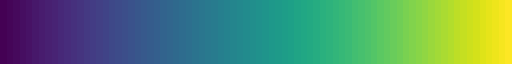

In [80]:
colormap

In [81]:
colormap.colors.shape

(80, 4)

In [82]:
print( *(colormap.colors[0,:3]) )

0.267004 0.004874 0.329415


In [83]:
colorMap_filename = OUTPUT_PREFIX + '.cmap'
with open( OUTPUT_FOLDER + colorMap_filename , 'w' ) as OUT:
    print('' , file=OUT)
    print('{} #{}'.format(nb_colors,COLORMAP), file=OUT)
    for i in range(nb_colors):
        print( *(colormap.colors[i,:3]) , file=OUT)

    

# step 6: configure an asset file

Part 1 of the file : definition and files

In [84]:
preamble = """
-- Scale factor --
local scale = 50


local texture = asset.localResource("point3A.png")
local color_map_file = asset.localResource("{}")

""".format(colorMap_filename)
speck_file_def = """-- Speck files --
local speck_file = asset.localResource("{}.speck")
""".format(OUTPUT_PREFIX)

label_files_def = "-- Label files --\n"
for col in label_columns:
    label_files_def += 'local label_file_{} = asset.localResource("{}.label")'.format(col , OUTPUT_PREFIX +'.'+col)

part 2 of the file, define the asset

In [85]:
    
asset_def = """
local {} = {{
  Identifier = "{}",""".format(OUTPUT_PREFIX,OUTPUT_PREFIX) 
asset_def+= """  Renderable = {
    Type = "RenderableCosmicPoints",
    Color = { 1, 0.067, 0.161 },
    Opacity = 1.0,
    ScaleFactor = scale,
    File = speck_file,
    ColorMap = color_map_file,\n"""

In [86]:
## color options : by default I create 1 option per metadata columns
asset_def+= "    ColorOption = { " +' , '.join(["'{}'".format(c) for c in non_label_columns+label_columns_int_cols ]) + " },\n"


rangeTexts = []
## the color ranges depend on the columns range
for c in non_label_columns+label_columns_int_cols:
    m = df[c].min()
    M = df[c].max()
    rangeTexts.append('{{ {} , {} }}'.format(m,M))
    
    
asset_def+= "    ColorRange = { " + ' , '.join(rangeTexts) + '},\n'


In [87]:
## here using the first label columns :
if len(label_columns)>0:
    asset_def+= "    LabelFile = label_file_{} ,\n".format( label_columns[0] )
    

In [88]:
asset_def+="""    Unit = "Km",
    Texture = texture,
    BillboardMinMaxSize = { 0.0, 250.0 }, -- in pixels
    EnablePixelSizeControl = true,
    Enabled = false
  },"""

asset_def+="""  GUI = {{
    Name = "{}",
    Path = "/{}"
  }}
}}
""".format(OUTPUT_PREFIX,OUTPUT_PREFIX)

print(asset_def)


local toy_data = {
  Identifier = "toy_data",  Renderable = {
    Type = "RenderableCosmicPoints",
    Color = { 1, 0.067, 0.161 },
    Opacity = 1.0,
    ScaleFactor = scale,
    File = speck_file,
    ColorMap = color_map_file,
    ColorOption = { 'KRT81' , 'MT1E' , 'SAA1' , 'GAGE12D' , 'SEC61G' , 'cell_line_int' },
    ColorRange = { { 0 , 861 } , { 0 , 386 } , { 0 , 398 } , { 0 , 173 } , { 0 , 2024 } , { 0 , 4 }},
    LabelFile = label_file_cell_line ,
    Unit = "Km",
    Texture = texture,
    BillboardMinMaxSize = { 0.0, 250.0 }, -- in pixels
    EnablePixelSizeControl = true,
    Enabled = false
  },  GUI = {
    Name = "toy_data",
    Path = "/toy_data"
  }
}



In [89]:
final_part = """
  asset.onInitialize(function()
    openspace.addSceneGraphNode({0})
    end)

asset.onDeinitialize(function()
    openspace.removeSceneGraphNode({0})
end)
""".format(OUTPUT_PREFIX)

In [90]:
with open( OUTPUT_FOLDER + OUTPUT_PREFIX + ".asset" , 'w' ) as OUT:
    print(preamble , file=OUT)
    print(speck_file_def , file=OUT)
    print(label_files_def , file=OUT)
    print(asset_def , file=OUT)
    print(final_part , file=OUT)

    

In [91]:
!cat output/toy_data.asset


-- Scale factor --
local scale = 50


local texture = asset.localResource("point3A.png")
local color_map_file = asset.localResource("toy_data.cmap")


-- Speck files --
local speck_file = asset.localResource("toy_data.speck")

-- Label files --
local label_file_cell_line = asset.localResource("toy_data.cell_line.label")

local toy_data = {
  Identifier = "toy_data",  Renderable = {
    Type = "RenderableCosmicPoints",
    Color = { 1, 0.067, 0.161 },
    Opacity = 1.0,
    ScaleFactor = scale,
    File = speck_file,
    ColorMap = color_map_file,
    ColorOption = { 'KRT81' , 'MT1E' , 'SAA1' , 'GAGE12D' , 'SEC61G' , 'cell_line_int' },
    ColorRange = { { 0 , 861 } , { 0 , 386 } , { 0 , 398 } , { 0 , 173 } , { 0 , 2024 } , { 0 , 4 }},
    LabelFile = label_file_cell_line ,
    Unit = "Km",
    Texture = texture,
    BillboardMinMaxSize = { 0.0, 250.0 }, -- in pixels
    EnablePixelSizeControl = true,
    Enabled = false
  },  GUI = {
    Name = "toy_data",
    Path = "/toy_data"
  }
}

## step 6 copy some resource file to the output folder

this will simplify the configuration of the asset file

In [92]:
import shutil

shutil.copy('resources/point3A.png', OUTPUT_FOLDER)

'output/point3A.png'

Checking the content of the output folder :

In [93]:
import os
os.listdir(OUTPUT_FOLDER)

['toy_data.asset',
 'point3A.png',
 'toy_data.cell_line.label',
 'toy_data.speck',
 'test.cmap',
 'toy_data.cmap']